In [1]:
import numpy as np
import pandas as pd
import pickle

import tensorflow as tf
import math
import json

from sklearn.model_selection import *
from sklearn import metrics

from daf.datasets import atti_dataset
from daf.utils import dataset_utils
from daf.utils import keras_util

import random

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Use Regularization

In [2]:
(x_train, y_train), (x_test, y_test) = atti_dataset.load_data(num_words=None)
label_index_dict = atti_dataset.get_label_index()

num_words = max([max(x) for x in x_train]) + 1
num_words

34731

In [3]:
print('Total of {} classes'.format(len(label_index_dict)))
label_index_dict

Total of 28 classes


{'ALTRI UFFICI': 0,
 'AVVOCATURA REGIONALE                                  ': 1,
 'D.G.  AVVOCATURA                                      ': 2,
 "D.G. COMPETITIVITA' DEL SISTEMA REGIONALE E SVILUPPO D": 3,
 'D.G. PRESIDENZA                                       ': 4,
 'DIPARTIMENTO BILANCIO E FINANZE                       ': 5,
 'DIPARTIMENTO ORGANIZZAZIONE                           ': 6,
 'DIPARTIMENTO ORGANIZZAZIONE E RISORSE                 ': 7,
 'DIPARTIMENTO POLITICHE FORMATIVE E BENI CULTURALI     ': 8,
 'DIPARTIMENTO POLITICHE TERRITORIALI E AMBIENTALI      ': 9,
 'DIPARTIMENTO PRESIDENZA AFFARI LEGISLATIVI E GIURIDICI': 10,
 'DIPARTIMENTO SALUTE E POLITICHE SOLIDARIETA           ': 11,
 'DIPARTIMENTO SVILUPPO ECONOMICO                       ': 12,
 'DIREZIONE AGRICOLTURA E SVILUPPO RURALE': 13,
 "DIREZIONE ATTIVITA' PRODUTTIVE": 14,
 'DIREZIONE DIFESA DEL SUOLO E PROTEZIONE CIVILE': 15,
 'DIREZIONE DIRITTI DI CITTADINANZA E COESIONE SOCIALE': 16,
 'DIREZIONE GENERALE BILANCIO 

## Data Preparation

create the function to trasnform the x data

In [4]:
from functools import partial

def x_transformer(x_data):
    return partial(dataset_utils.vectorize_sequences, x_data, num_words)

def y_tranformer(y_data):
    return partial(dataset_utils.to_one_hot, y_data, num_classes)

In [5]:
x_transformer(x_train[0])().shape

(15, 34731)

In [6]:
batch_size = 128
num_classes = len(set(y_train))
train_val_split = math.ceil(len(x_train) * 0.8)
print('num classes {}'.format(num_classes))
print('training size {}, validation size {}'.format(train_val_split, len(x_train) - train_val_split))

num classes 28
training size 97726, validation size 24431


In [7]:
train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, train_val_split, True)

val_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer,
                                                    batch_size, train_val_split, len(x_train), False)

train_steps = train_val_split // batch_size + 1
val_steps = (len(x_train) - train_val_split) // batch_size + 1

## Build the Models

apart the base model we add new methods with different kind of regularizers. In particular, we take into account:
- l2 that penalize the weights coefficient with a value proportional of their l1 and l2 norms. The general idea is that we prefer a simple model where the distribution of parameters values has less entropy.
- dropout where the idea is to reset randomly a percentage of the weights to zero in order to avoid that neurons start to memorize noise patterns.

In [8]:
def build_base_model(neurons, num_words, num_classes):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(num_words, ))
    l = tf.keras.layers.Dense(neurons, activation='relu')(input_l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [9]:
def build_l2_model(neurons, num_words, num_classes):
    keras_util.new_session()
    input_l = tf.keras.Input(shape=(num_words, ))
    l = tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_l)
    l = tf.keras.layers.Dense(neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [24]:
def build_dropout_model(neurons, num_words, num_classes, dropout=0.5):
    input_l = tf.keras.Input(shape=(num_words, ))
    l = tf.keras.layers.Dense(neurons, activation='relu')(input_l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    l = tf.keras.layers.Dense(neurons, activation='relu')(l)
    l = tf.keras.layers.Dropout(dropout)(l)
    output_l = tf.keras.layers.Dense(num_classes, activation='softmax')(l)
    model = tf.keras.Model(inputs=input_l, outputs=output_l)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
def train(neurons, epochs):
    histories = {}
    models = {
        "l2_regularization": build_l2_model,
        "droupout_regularization": build_dropout_model
    }
    for name, model_f in models.items():
        model = model_f(neurons, num_words, num_classes)
        print(model.summary())
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir="logs/{}_{}".format(name, neurons)),
            tf.keras.callbacks.EarlyStopping(patience=5, verbose=1),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)
            ]  
        
        history = model.fit_generator(train_generator, steps_per_epoch=train_steps, epochs=epochs, 
                      validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)

        histories[name] = history

In [26]:
histories = train(128, 15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34731)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4445696   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 28)                3612      
Total params: 4,482,332
Trainable params: 4,482,332
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
764/764 [==============================] - 24s 32ms/step - loss: 1.3275 - acc: 0.7062 - val_loss: 1.2040 - val_acc: 

In [ ]:
histories = train(256, 15)

In [27]:
histories = train(512, 15)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 34731)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               17782784  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 28)                14364     
Total params: 18,322,460
Trainable params: 18,322,460
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
764/764 [==============================] - 33s 43ms/step - loss: 1.4214 - acc: 0.7212 - val_loss: 1.3432 - val_acc

## Build the final model

the best model is obtained with 512 neurons and 3 epochs

In [25]:
train_steps = len(x_train) // batch_size + 1

train_generator = dataset_utils.dataset_generator_fun(x_train, y_train, x_transformer, y_tranformer, 
                                                      batch_size, 0, len(x_train), True)

In [26]:
model = build_dropout_model(512, num_words, num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 34731)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               17782784  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [27]:
history = model.fit_generator(train_generator, train_steps, 5)

Epoch 1/5
955/955 [==============================] - 33s 34ms/step - loss: 0.9691 - acc: 0.6963
Epoch 2/5
955/955 [==============================] - 32s 34ms/step - loss: 0.4801 - acc: 0.8448
Epoch 3/5
955/955 [==============================] - 32s 34ms/step - loss: 0.3661 - acc: 0.8820
Epoch 4/5
955/955 [==============================] - 32s 34ms/step - loss: 0.2998 - acc: 0.9043
Epoch 5/5
955/955 [==============================] - 33s 34ms/step - loss: 0.2563 - acc: 0.9186


In [28]:
model.save('../checkpoints/final_model.hdf5')

In [26]:
import gc
gc.collect()

0

## Evaluate on the test set

In [20]:
x_test_v = dataset_utils.vectorize_sequences(x_test, num_words)
y_test_v = dataset_utils.to_one_hot(y_test, num_classes)

In [21]:
test_predictions = model.predict(x_test_v, verbose=1)

30540/30540 [==============================] - 6s 204us/step


In [22]:
predictions = np.array([np.argmax(x) for x in test_predictions])
precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test,predictions, average='weighted')
accuracy = metrics.accuracy_score(y_test, predictions)

auc_score = metrics.roc_auc_score(y_test_v, test_predictions, average='weighted')

print('accuracy ', accuracy)
print('precision ', precision)
print('recall ', recall)
print('f-measure ', fscore)

accuracy  0.8412573673870334
precision  0.8416979596722733
recall  0.8412573673870334
f-measure  0.8407591545454339


### Report the classification result for each class

In [30]:
print(metrics.classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.71      0.62      0.66       158
          1       0.64      0.67      0.66       217
          2       0.89      0.87      0.88       686
          3       0.86      0.83      0.84      2765
          4       0.86      0.83      0.85      1658
          5       0.75      0.73      0.74       289
          6       0.75      0.64      0.69       606
          7       0.63      0.64      0.63       316
          8       0.79      0.80      0.80       669
          9       0.87      0.84      0.86      1432
         10       0.80      0.82      0.81       542
         11       0.86      0.71      0.78       767
         12       0.79      0.83      0.81       985
         13       0.97      0.97      0.97      2718
         14       0.85      0.85      0.85       370
         15       0.98      0.93      0.96      1142
         16       0.88      0.85      0.87      1890
         17       0.72      0.79      0.75   

### Confusion Matrix

In [31]:
conf_matrix = metrics.confusion_matrix(y_test, predictions)

In [32]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
np.set_printoptions(precision=2)

Confusion matrix, without normalization


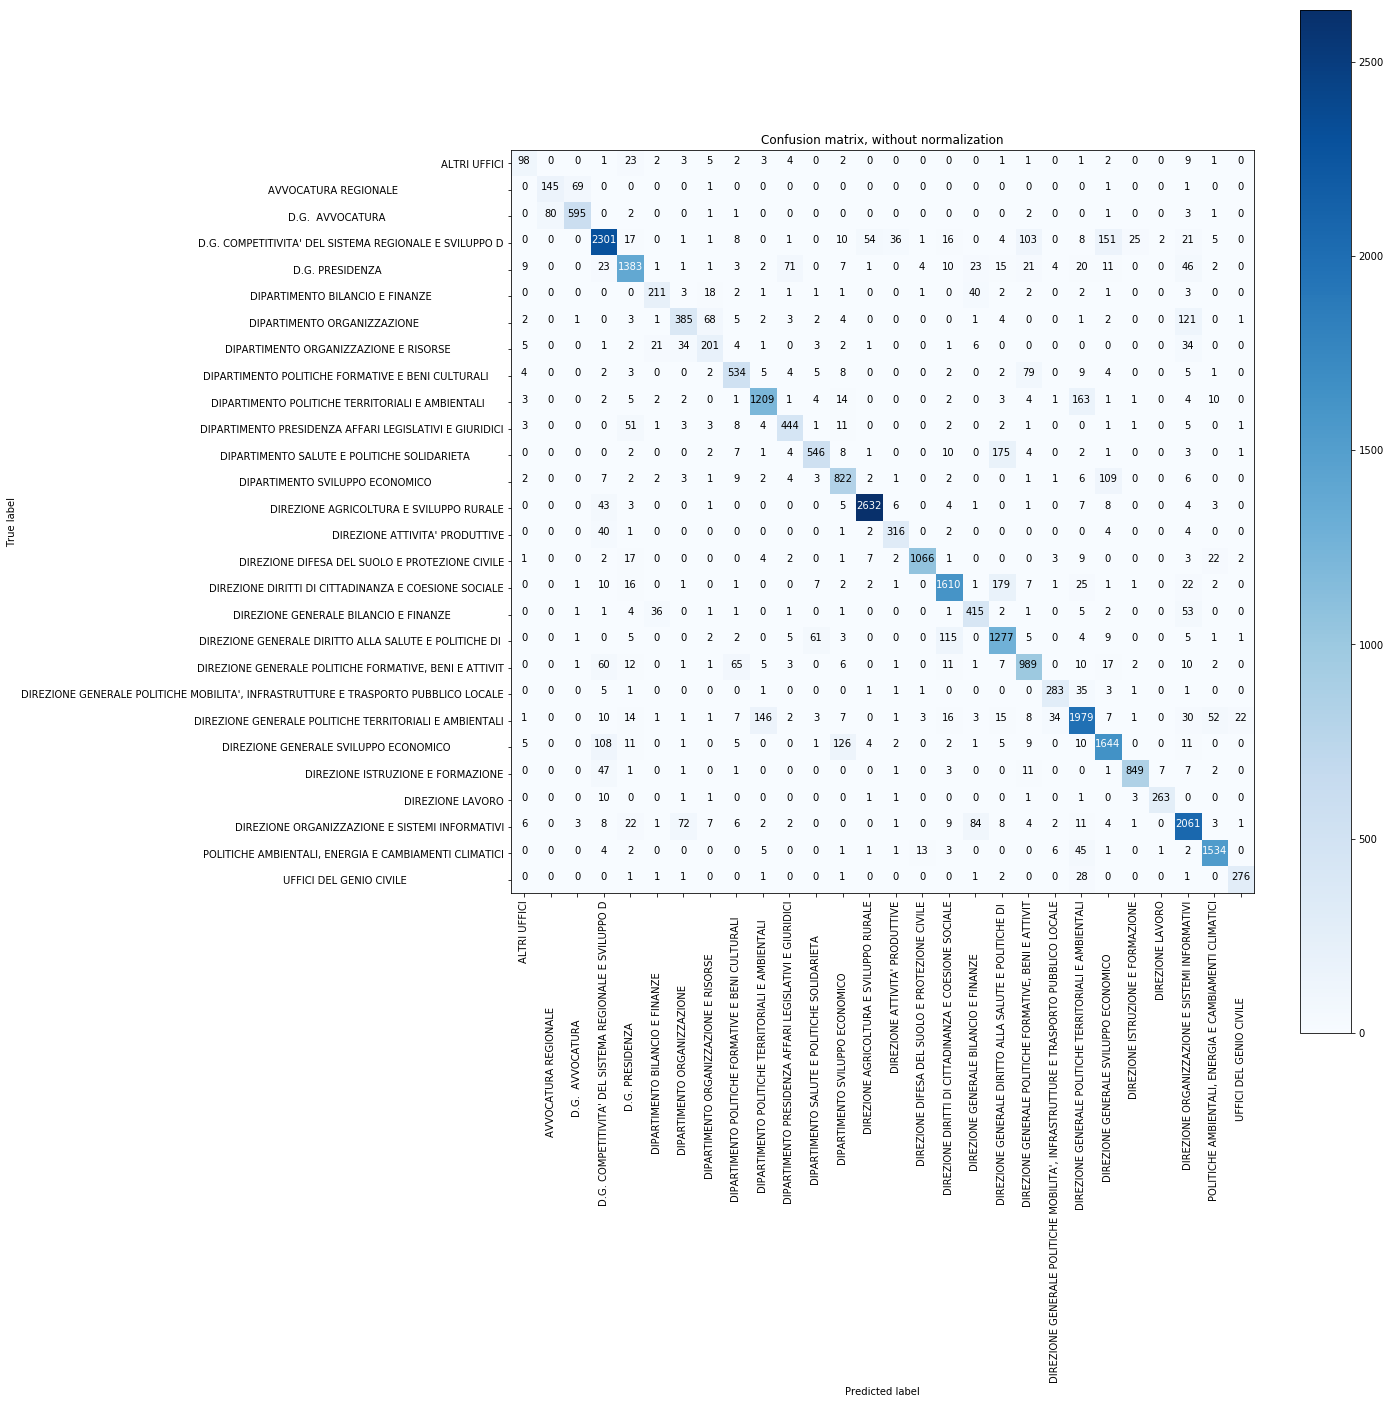

In [33]:
plt.rcParams['figure.figsize'] = (20,20)
plot_confusion_matrix(conf_matrix, classes=label_index_dict,
                      title='Confusion matrix, without normalization')